In [1]:
# code here
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
%matplotlib inline
import os
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from google.colab import drive
from torchsummary import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# code here
BATCH_SIZE = 64
transform = transforms.Compose([
                    transforms.ToTensor(), 
            ])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size= BATCH_SIZE, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:05<00:00, 29235913.74it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls /content/drive/MyDrive

'Colab Notebooks'		  test_loss_Dropout.npy
 model_adam_exponential.pth	  test_loss_rmsprop.npy
 model_adam_multistep.pth	  test_loss_sgd_L2.npy
 model_adam.pth			  test_loss_sgd_momentum.npy
 model_BN_Dropout.pth		  test_loss_sgd.npy
 model_BN.pth			  test_loss_stochastic.npy
 model_Dropout.pth		  train_loss_adam_exponential.npy
 model_rmsprop.pth		  train_loss_adam_multistep.npy
 model_sgd_L2.pth		  train_loss_adam.npy
 model_sgd_momentum.pth		  train_loss_BN_Dropout.npy
 model_sgd.pth			  train_loss_BN.npy
 model_stochastic.pth		  train_loss_Dropout.npy
 Test.gdoc			  train_loss_rmsprop.npy
 test_loss_adam_exponential.npy   train_loss_sgd_L2.npy
 test_loss_adam_multistep.npy	  train_loss_sgd_momentum.npy
 test_loss_adam.npy		  train_loss_sgd.npy
 test_loss_BN_Dropout.npy	  train_loss_stochastic.npy
 test_loss_BN.npy


torch.Size([64, 3, 32, 32])
torch.Size([64])


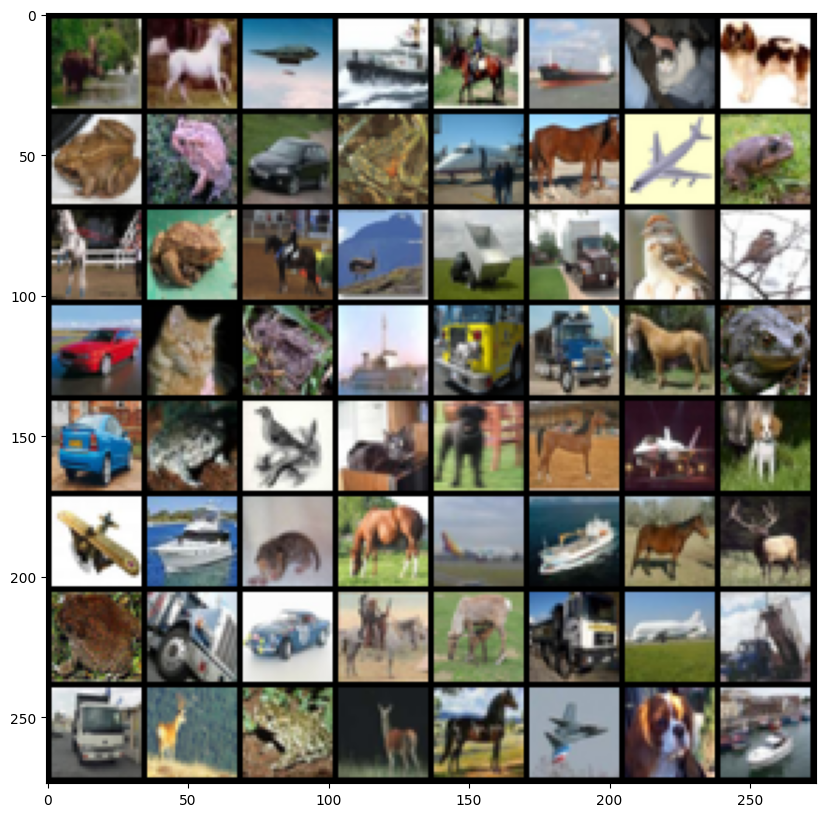

In [6]:
# let's have a look at the dataset
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))

In [7]:
labels = ["AIRPLANE", "AUTOMOBILE", "BIRD", "CAT", "DEER", "DOG", "FROG", "HORSE", "SHIP", "TRUCK"]

## Teacher Model

In [8]:
# Plot train and validation loss
def plot_losses(train_loss,val_loss,name):

  x_data=np.arange(0,len(train_loss))
  plt.plot(x_data,train_loss,label="train")
  plt.plot(x_data,val_loss,label="validation")
  plt.legend()
  plt.title(name)
  plt.show()

  return

In [18]:
# Get accuracy, precision, recall and f1 score of the model
def get_metrics(model):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for idx, (data,label) in enumerate(testloader):
            data = data.to(device)
            label = label.to(device)
            y_true.extend(label.cpu().numpy())
            o_, output = model(data)
            y_pred.extend(torch.argmax(output, dim=1).cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, precision, recall, f1

In [9]:
class Teacher(nn.Module):
    def __init__(self, feature=False):
        super(Teacher, self).__init__()
        self.feature = feature
        self.channel1 = 32
        self.channel2 = 64
        self.channel3 = 128
        self.layer1 = 2048
        self.layer2 = 128

        self.conv1 = nn.Conv2d(3, self.channel1, 3, padding=1)
        self.conv2 = nn.Conv2d(self.channel1, self.channel1, 3, padding=1)

        self.conv3 = nn.Conv2d(self.channel1, self.channel2, 3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(self.channel2, self.channel2, 3, padding=1, stride=1)

        self.conv5 = nn.Conv2d(self.channel2, self.channel3, 3, padding=1)
        self.conv6 = nn.Conv2d(self.channel3, self.channel3, 3, padding=1)

        self.linear1 = nn.Linear(self.layer1, self.layer2)
        self.linear2 = nn.Linear(self.layer2, 10)

        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.relu(x)
        x, ind2 = self.pool(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x_n = x
        x, ind4 = self.pool(x)
        x = self.dropout(x)

        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)
        x, ind6 = self.pool(x)
        x = self.dropout(x)

        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)

        x = self.relu(self.linear2(x))
        # x  = self.sigmoid(x)
        return x_n, x

In [10]:
teacher = Teacher().to(device)
summary(teacher, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           9,248
              ReLU-4           [-1, 32, 32, 32]               0
         MaxPool2d-5  [[-1, 32, 16, 16], [-1, 32, 16, 16]]               0
           Dropout-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          18,496
              ReLU-8           [-1, 64, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          36,928
             ReLU-10           [-1, 64, 16, 16]               0
        MaxPool2d-11  [[-1, 64, 8, 8], [-1, 64, 8, 8]]               0
          Dropout-12             [-1, 64, 8, 8]               0
           Conv2d-13            [-1, 128, 8, 8]          73,856
             ReLU-14 

In [15]:
def train_teacher(model, name, num_epochs=10):
    optimiser = optim.Adam(model.parameters(), lr=1e-3)
    # loss_func = nn.MSELoss().to(device)
    loss_func = nn.CrossEntropyLoss().to(device)
    train_loss, val_loss = list(), list()

    for epoch in range(num_epochs):
        model.train()
        x = 0
        for batch_idx, (data, target) in enumerate(trainloader):
            data = data.to(device)
            target = target.to(device)

            optimiser.zero_grad()

            d_, d = model(data)
            # print(d)
            loss = loss_func(d, target)
            x += loss.cpu().data.item()
            loss.backward()
            optimiser.step()
        x = x / len(trainloader)
        train_loss.append(x)

        model.eval()
        with torch.no_grad():
            x = 0
            for batch_idx, (data, target) in enumerate(testloader):
                data = data.to(device)
                target = target.to(device)

                d_, d = model(data)
                loss = loss_func(d, target)
                x += loss.item()
            x = x/len(testloader)
            val_loss.append(x)
        print("Epoch: {}, Train Loss: {:.4f}, Test Loss: {:.4f}".format(epoch+1,train_loss[-1],val_loss[-1]))
        
    plot_losses(train_loss, val_loss, name)
    return model, train_loss, val_loss

Epoch: 1, Train Loss: 1.8374, Test Loss: 1.3803
Epoch: 2, Train Loss: 1.3347, Test Loss: 1.2046
Epoch: 3, Train Loss: 1.1567, Test Loss: 1.0133
Epoch: 4, Train Loss: 1.0429, Test Loss: 0.9725
Epoch: 5, Train Loss: 0.9546, Test Loss: 0.8898
Epoch: 6, Train Loss: 0.8858, Test Loss: 0.8136
Epoch: 7, Train Loss: 0.8297, Test Loss: 0.8029
Epoch: 8, Train Loss: 0.7818, Test Loss: 0.7537
Epoch: 9, Train Loss: 0.7486, Test Loss: 0.7225
Epoch: 10, Train Loss: 0.7150, Test Loss: 0.6949


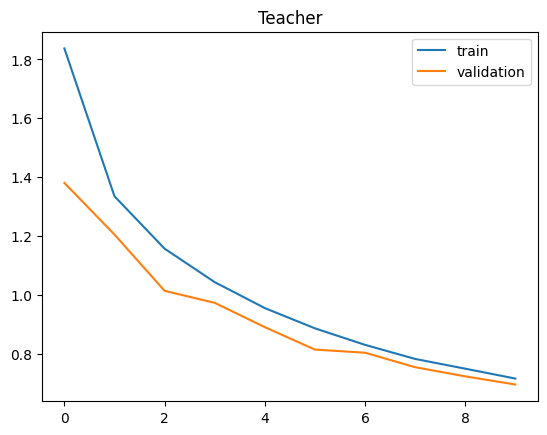

In [16]:
epochs = 10
teacher = Teacher().to(device)
teacher, train_loss_teacher, val_loss_teacher = train_teacher(teacher, 'Teacher', num_epochs=epochs)

In [19]:
# Save the model and losses
torch.save(teacher.state_dict(), '/content/drive/MyDrive/teacher.pth')

np.save('/content/drive/MyDrive/teacher_train_loss.npy', train_loss_teacher)
np.save('/content/drive/MyDrive/teacher_val_loss.npy', val_loss_teacher)

In [21]:
path =  '/content/drive/MyDrive/teacher.pth'
teacher.load_state_dict(torch.load(path))
teacher

Teacher(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=2048, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
)

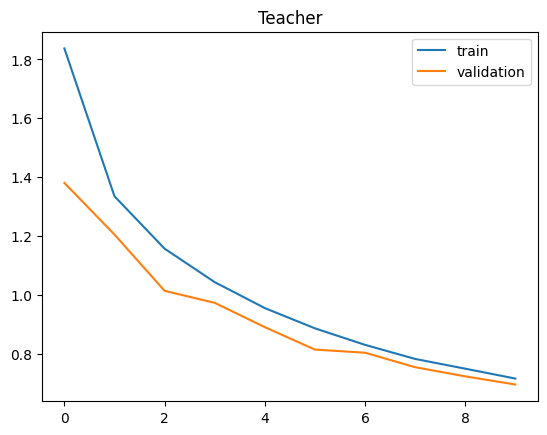

In [22]:
# Plot the losses
train_loss = np.load('/content/drive/MyDrive/teacher_train_loss.npy')
val_loss = np.load('/content/drive/MyDrive/teacher_val_loss.npy')

plot_losses(train_loss, val_loss, 'Teacher')

In [23]:
# Get the metrics
acc,p,re,f1 = get_metrics(teacher)
print("Accuracy: ", acc)
print("Precision: ", p)
print("Recall: ", re)
print("F1 Score: ", f1)


Accuracy:  0.7593
Precision:  0.7589836467176277
Recall:  0.7593000000000001
F1 Score:  0.7560550468712536


## Student Model

In [46]:
class Student(nn.Module):
    def __init__(self, feature=False):
        super(Student, self).__init__()
        self.feature = feature
        self.channel1 = 16
        self.channel2 = 32
        self.channel3 = 64
        self.layer1 = 1600
        self.layer2 = 64

        self.conv1 = nn.Conv2d(3, self.channel1, 3, padding=0)
        self.conv2 = nn.Conv2d(self.channel1, self.channel1, 3, padding=1)

        self.conv3 = nn.Conv2d(self.channel1, self.channel2, 3, padding=0, stride=1)
        self.conv4 = nn.Conv2d(self.channel2, self.channel2, 3, padding=1, stride=1)

        self.conv5 = nn.Conv2d(self.channel2, self.channel2, 3, padding=0)
        self.conv6 = nn.Conv2d(self.channel2, self.channel2, 3, padding=1)

        ############### REGRESSOR ################################
        self.S_regressor = nn.Conv2d(self.channel2, self.channel3, 13, padding=1)
        #########################################################

        self.conv7 = nn.Conv2d(self.channel2, self.channel3, 3, padding=0)
        self.conv8 = nn.Conv2d(self.channel3, self.channel3, 3, padding=1)

        self.conv9 = nn.Conv2d(self.channel3, self.channel3, 3, padding=0)
        self.conv10 = nn.Conv2d(self.channel3, self.channel3, 3, padding=1)

        self.linear1 = nn.Linear(self.layer1, self.layer2)
        self.linear2 = nn.Linear(self.layer2, 10)

        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)

        x_n = self.S_regressor(x)

        x = self.conv7(x)
        x = self.relu(x)
        x = self.conv8(x)
        x = self.relu(x)
        x, ind1 = self.pool(x)

        x = self.conv9(x)
        x = self.relu(x)
        x = self.conv10(x)
        x = self.relu(x)
        x, ind2 = self.pool(x)

        x = self.flatten(x)
        x = self.relu(self.linear1(x))

        x = self.sigmoid(self.linear2(x))
        return x_n, x

In [47]:
student = Student().to(device)
summary(student, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
              ReLU-2           [-1, 16, 30, 30]               0
            Conv2d-3           [-1, 16, 30, 30]           2,320
              ReLU-4           [-1, 16, 30, 30]               0
            Conv2d-5           [-1, 32, 28, 28]           4,640
              ReLU-6           [-1, 32, 28, 28]               0
            Conv2d-7           [-1, 32, 28, 28]           9,248
              ReLU-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 32, 26, 26]           9,248
             ReLU-10           [-1, 32, 26, 26]               0
           Conv2d-11           [-1, 32, 26, 26]           9,248
             ReLU-12           [-1, 32, 26, 26]               0
           Conv2d-13           [-1, 64, 16, 16]         346,176
           Conv2d-14           [-1, 64,

### Baseline

In [49]:
def train_student(model, name, num_epochs=10):
    optimiser = optim.Adam(model.parameters(), lr=1e-3)
    # loss_func = nn.MSELoss().to(device)
    loss_func = nn.CrossEntropyLoss().to(device)
    train_loss, val_loss = list(), list()

    for epoch in range(num_epochs):
        model.train()
        x = 0
        for batch_idx, (data, target) in enumerate(trainloader):
            data = data.to(device)
            target = target.to(device)

            optimiser.zero_grad()

            d_, d = model(data)
            loss = loss_func(d, target)
            x += loss.cpu().data.item()
            loss.backward()
            optimiser.step()
        x = x / len(trainloader)
        train_loss.append(x)

        model.eval()
        with torch.no_grad():
            x = 0
            for batch_idx, (data, target) in enumerate(testloader):
                data = data.to(device)
                target = target.to(device)

                d_, d = model(data)
                loss = loss_func(d, target)
                x += loss.item()
            x = x/len(testloader)
            val_loss.append(x)
        print("Epoch: {}, Train Loss: {:.4f}, Test Loss: {:.4f}".format(epoch+1,train_loss[-1],val_loss[-1]))
        
    plot_losses(train_loss, val_loss, name)
    return model, train_loss, val_loss

Epoch: 1, Train Loss: 2.0907, Test Loss: 2.0284
Epoch: 2, Train Loss: 1.9894, Test Loss: 1.9436
Epoch: 3, Train Loss: 1.9495, Test Loss: 1.9216
Epoch: 4, Train Loss: 1.9183, Test Loss: 1.9404
Epoch: 5, Train Loss: 1.8965, Test Loss: 1.8943


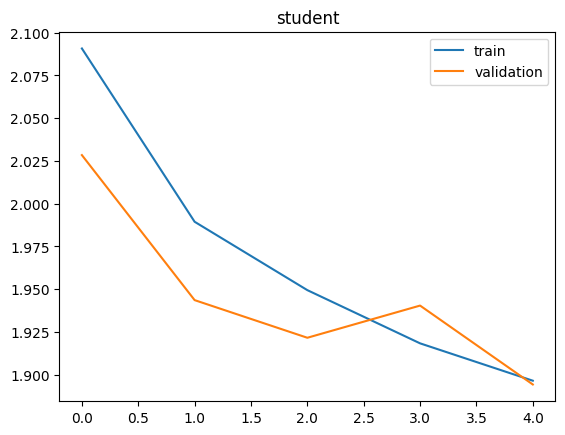

In [50]:
epochs = 5
student = Student().to(device)
student, train_loss, val_loss = train_student(student, 'student', num_epochs=epochs)

In [28]:
# Save the model and losses
torch.save(student.state_dict(), '/content/drive/MyDrive/student.pth')

np.save('/content/drive/MyDrive/student_train_loss.npy', train_loss)
np.save('/content/drive/MyDrive/student_val_loss.npy', val_loss)

In [29]:
path =  '/content/drive/MyDrive/student.pth'
student.load_state_dict(torch.load(path))
student

Student(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (S_regressor): Conv2d(32, 64, kernel_size=(13, 13), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=1600, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

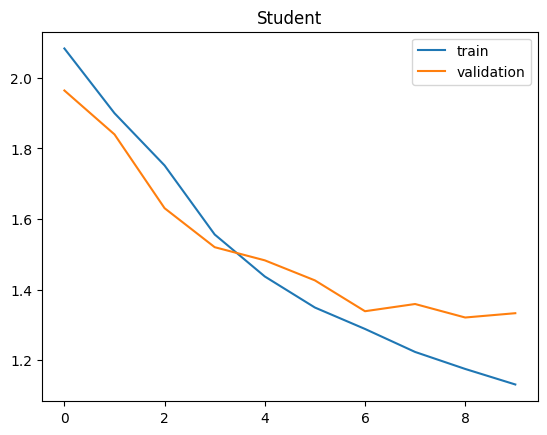

In [30]:
# Plot the losses
train_loss = np.load('/content/drive/MyDrive/student_train_loss.npy')
val_loss = np.load('/content/drive/MyDrive/student_val_loss.npy')

plot_losses(train_loss, val_loss, 'Student')

In [51]:
# Get the metrics
acc,p,re,f1 = get_metrics(student)
print("Accuracy: ", acc)
print("Precision: ", p)
print("Recall: ", re)
print("F1 Score: ", f1)


Accuracy:  0.4116
Precision:  0.4094037142946133
Recall:  0.41159999999999997
F1 Score:  0.39201097771021737


## Distiller

In [54]:
def distiller(teacher_model, student_model, alpha=0.1, temperature=3, is_KD_train=False, num_epochs=10):
    optimiser = optim.Adam(student_model.parameters(), lr=1e-3)
    
    student_loss_fn = nn.CrossEntropyLoss().to(device)
    
    # distillation_loss_fn = nn.MSELoss().to(device) # for FitNets
    # distillation_loss_fn = nn.KLDivLoss().to(device) # for Hinton
    if(is_KD_train == False):
      distillation_loss_fn = nn.MSELoss().to(device)
    else:
      distillation_loss_fn = nn.KLDivLoss().to(device)

    softmax = nn.Softmax(dim=1)
    train_loss, val_loss = list(), list()
    student_loss_train = list()

    student_model.train()

    for epoch in range(num_epochs):
        x = 0
        for batch_idx, (data, target) in enumerate(trainloader):
            data = data.to(device)
            target = target.to(device)

            optimiser.zero_grad()

            teacher_preds1, teacher_preds2 = teacher_model(data)
            student_preds1, student_preds2 = student_model(data)
            # Compute student loss
            if is_KD_train == True:
                student_loss = student_loss_fn(student_preds2, target)
                teacher_pred_mod = softmax(teacher_preds2/temperature)
                student_pred_mod = softmax(student_preds2/temperature)
            else:
                student_loss = 0.0
                teacher_pred_mod = softmax(teacher_preds1/temperature)
                student_pred_mod = softmax(student_preds1/temperature)

            # Compute distillation loss
            distillation_loss = distillation_loss_fn(student_pred_mod, teacher_pred_mod)

            # Compute aggregate loss
            loss = alpha*distillation_loss + (1 - alpha)*student_loss
            # print('loss', loss)

            x += loss.cpu().data.item()
            loss.backward()
            optimiser.step()
        x = x / len(trainloader)
        train_loss.append(x)

        student_model.eval()
        with torch.no_grad():
            x = 0
            for batch_idx, (data, target) in enumerate(testloader):
                data = data.to(device)
                target = target.to(device)

                d_, d = student_model(data)
                loss = student_loss_fn(d, target)
                x += loss.item()
            x = x/len(testloader)
            val_loss.append(x)
        print("Epoch: {}, Train Loss: {:.4f}, Test Loss: {:.4f}".format(epoch+1,train_loss[-1],val_loss[-1]))
        # if is_KD_train:
        #     print("Epoch: {}, Train Loss: {:.4f}, Test Loss: {:.4f}".format(epoch+1,train_loss[-1],val_loss[-1]))
        # else:
        #     print("Epoch: {}, Train Loss: {:.4f}".format(epoch+1,train_loss[-1]))
    
    if(is_KD_train == False):
      name = 'Feature Based (Fitnets)'
    else:
      name = 'Response Based'

    plot_losses(train_loss, val_loss, name)
    return student_model, train_loss, val_loss


### Response Based Learning

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch: 1, Train Loss: 1.6328, Test Loss: 2.0170
Epoch: 2, Train Loss: 1.5460, Test Loss: 1.9654
Epoch: 3, Train Loss: 1.5100, Test Loss: 1.9329
Epoch: 4, Train Loss: 1.4874, Test Loss: 1.9230
Epoch: 5, Train Loss: 1.4700, Test Loss: 1.8871
Epoch: 6, Train Loss: 1.4557, Test Loss: 1.8726
Epoch: 7, Train Loss: 1.4401, Test Loss: 1.8586
Epoch: 8, Train Loss: 1.4317, Test Loss: 1.8431
Epoch: 9, Train Loss: 1.4176, Test Loss: 1.8608
Epoch: 10, Train Loss: 1.4085, Test Loss: 1.8462


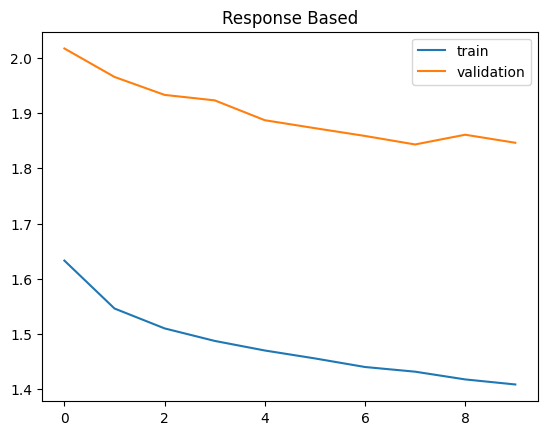

In [55]:
student_resp = Student().to(device)
student_resp, train_loss, val_loss = distiller(teacher, student_resp, alpha=0.2, temperature=10, is_KD_train=True)

In [59]:
# Save the model and losses
torch.save(student_resp.state_dict(), '/content/drive/MyDrive/student_resp.pth')

np.save('/content/drive/MyDrive/student_resp(0.2,10)_train_loss.npy', train_loss)
np.save('/content/drive/MyDrive/student_resp(0.2,10)_val_loss.npy', val_loss)

In [60]:
path =  '/content/drive/MyDrive/student_resp.pth'
student_resp.load_state_dict(torch.load(path))
student_resp

Student(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (S_regressor): Conv2d(32, 64, kernel_size=(13, 13), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=1600, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

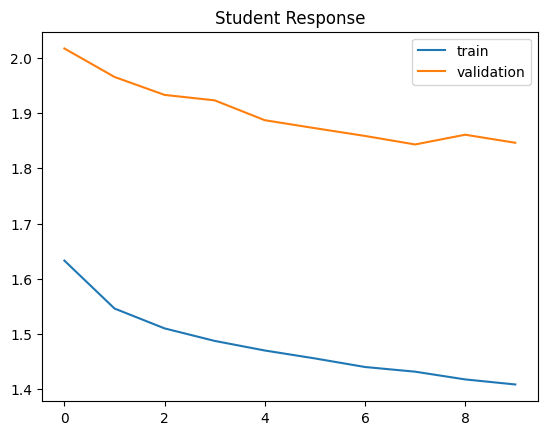

In [61]:
# Plot losses
train_loss = np.load('/content/drive/MyDrive/student_resp(0.2,10)_train_loss.npy')
val_loss = np.load('/content/drive/MyDrive/student_resp(0.2,10)_val_loss.npy')

plot_losses(train_loss, val_loss, 'Student Response')

In [62]:
# Get Metrics

acc,p,re,f1 = get_metrics(student_resp)
print("Accuracy: ", acc)
print("Precision: ", p)
print("Recall: ", re)
print("F1 Score: ", f1)


Accuracy:  0.4994
Precision:  0.497511449783876
Recall:  0.49939999999999996
F1 Score:  0.49126814525769713


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch: 1, Train Loss: 1.0107, Test Loss: 2.1186
Epoch: 2, Train Loss: 0.8925, Test Loss: 1.9879
Epoch: 3, Train Loss: 0.8588, Test Loss: 1.9349
Epoch: 4, Train Loss: 0.8441, Test Loss: 1.9070
Epoch: 5, Train Loss: 0.8327, Test Loss: 1.8939
Epoch: 6, Train Loss: 0.8253, Test Loss: 1.8821
Epoch: 7, Train Loss: 0.8152, Test Loss: 1.8909
Epoch: 8, Train Loss: 0.8101, Test Loss: 1.8793
Epoch: 9, Train Loss: 0.8036, Test Loss: 1.8530
Epoch: 10, Train Loss: 0.7975, Test Loss: 1.8420


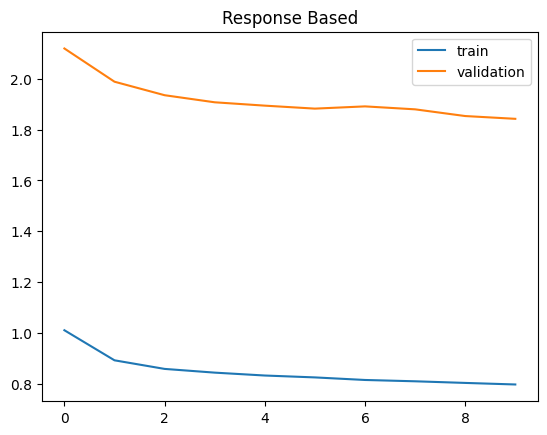

In [68]:
# Check for different alphas and Ts

# alpha = 0.5, T = 20
resp_ch = Student().to(device)
resp_ch, train_loss, val_loss = distiller(teacher, resp_ch, alpha=0.5, temperature=20, is_KD_train=True)

In [69]:
# Check metrics
acc,p,re,f1 = get_metrics(resp_ch)
print("Accuracy: ", acc)
print("Precision: ", p)
print("Recall: ", re)
print("F1 Score: ", f1)

Accuracy:  0.4796
Precision:  0.4944838377518058
Recall:  0.4795999999999999
F1 Score:  0.4671368526522919


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch: 1, Train Loss: 1.6320, Test Loss: 1.9982
Epoch: 2, Train Loss: 1.5447, Test Loss: 1.9586
Epoch: 3, Train Loss: 1.5171, Test Loss: 1.9318
Epoch: 4, Train Loss: 1.4976, Test Loss: 1.9123
Epoch: 5, Train Loss: 1.4768, Test Loss: 1.8929
Epoch: 6, Train Loss: 1.4643, Test Loss: 1.8762
Epoch: 7, Train Loss: 1.4474, Test Loss: 1.8607
Epoch: 8, Train Loss: 1.4365, Test Loss: 1.8606
Epoch: 9, Train Loss: 1.4254, Test Loss: 1.8667
Epoch: 10, Train Loss: 1.4143, Test Loss: 1.8368


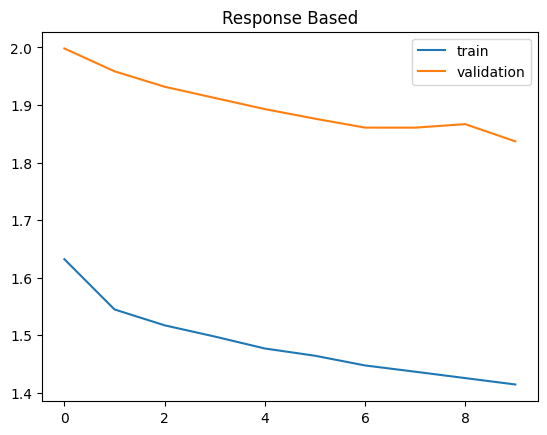

In [74]:
# alpha = 0.2, T = 5
resp_ch = Student().to(device)
resp_ch, train_loss, val_loss = distiller(teacher, resp_ch, alpha=0.2, temperature=5, is_KD_train=True)

In [75]:
# Check metrics
acc,p,re,f1 = get_metrics(resp_ch)
print("Accuracy: ", acc)
print("Precision: ", p)
print("Recall: ", re)
print("F1 Score: ", f1)

Accuracy:  0.5052
Precision:  0.5112902364592987
Recall:  0.5052000000000001
F1 Score:  0.501525115742108


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch: 1, Train Loss: 0.4598, Test Loss: 2.0011
Epoch: 2, Train Loss: 0.4286, Test Loss: 1.9607
Epoch: 3, Train Loss: 0.4172, Test Loss: 1.9280
Epoch: 4, Train Loss: 0.4075, Test Loss: 1.9148
Epoch: 5, Train Loss: 0.4009, Test Loss: 1.8956
Epoch: 6, Train Loss: 0.3945, Test Loss: 1.8709
Epoch: 7, Train Loss: 0.3888, Test Loss: 1.8649
Epoch: 8, Train Loss: 0.3831, Test Loss: 1.8482
Epoch: 9, Train Loss: 0.3779, Test Loss: 1.8231
Epoch: 10, Train Loss: 0.3738, Test Loss: 1.8400


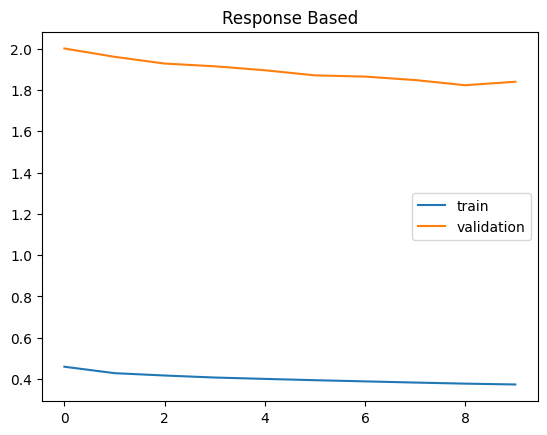

In [72]:
# alpha = 0.7, T = 40
resp_ch = Student().to(device)
resp_ch, train_loss, val_loss = distiller(teacher, resp_ch, alpha=0.7, temperature=40, is_KD_train=True)

In [73]:
# Check metrics
acc,p,re,f1 = get_metrics(resp_ch)
print("Accuracy: ", acc)
print("Precision: ", p)
print("Recall: ", re)
print("F1 Score: ", f1)

Accuracy:  0.4767
Precision:  0.5108544695867697
Recall:  0.4767
F1 Score:  0.46341345334345674


### Feature based learning

Epoch: 1, Train Loss: 0.0000, Test Loss: 2.3027
Epoch: 2, Train Loss: 0.0000, Test Loss: 2.3027
Epoch: 3, Train Loss: 0.0000, Test Loss: 2.3027
Epoch: 4, Train Loss: 0.0000, Test Loss: 2.3027
Epoch: 5, Train Loss: 0.0000, Test Loss: 2.3027
Epoch: 6, Train Loss: 0.0000, Test Loss: 2.3027
Epoch: 7, Train Loss: 0.0000, Test Loss: 2.3027
Epoch: 8, Train Loss: 0.0000, Test Loss: 2.3027
Epoch: 9, Train Loss: 0.0000, Test Loss: 2.3027
Epoch: 10, Train Loss: 0.0000, Test Loss: 2.3027


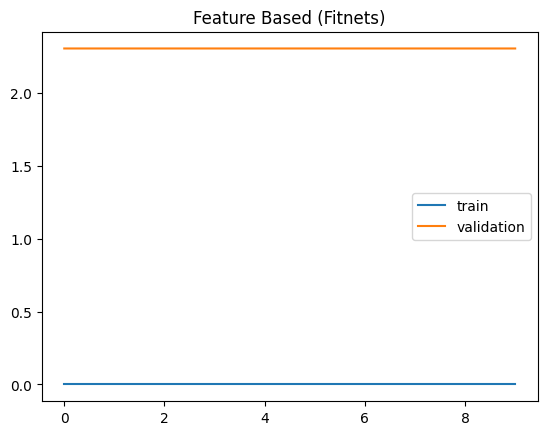

In [79]:
student_guided = Student().to(device)
student_gu, train_loss, val_loss = distiller(teacher, student_guided, alpha=1, temperature=5)

In [80]:
# Save the model and losses
torch.save(student_gu.state_dict(), '/content/drive/MyDrive/student_fe.pth')

np.save('/content/drive/MyDrive/student_fe(1,5)_train_loss.npy', train_loss)
np.save('/content/drive/MyDrive/student_fe(1,5)_val_loss.npy', val_loss)

In [81]:
path =  '/content/drive/MyDrive/student_fe.pth'
student_gu.load_state_dict(torch.load(path))
student_gu

Student(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (S_regressor): Conv2d(32, 64, kernel_size=(13, 13), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=1600, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

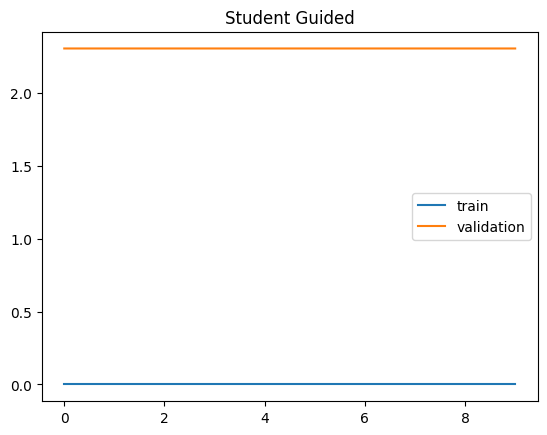

In [82]:
# Plot losses
train_loss = np.load('/content/drive/MyDrive/student_fe(1,5)_train_loss.npy')
val_loss = np.load('/content/drive/MyDrive/student_fe(1,5)_val_loss.npy')

plot_losses(train_loss, val_loss, 'Student Guided')


In [83]:
# Get Metrics
acc,p,re,f1 = get_metrics(student_gu)
print("Accuracy: ", acc)
print("Precision: ", p)
print("Recall: ", re)
print("F1 Score: ", f1)


Accuracy:  0.1
Precision:  0.01
Recall:  0.1
F1 Score:  0.01818181818181818


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Over-regularization of Fitnets

In [76]:
def distiller_reg(teacher_model, student_model, alpha=0.1, temperature=3, is_KD_train=False, num_epochs=10):
    optimiser = optim.Adam(student_model.parameters(), lr=1e-3)
    
    student_loss_fn = nn.CrossEntropyLoss().to(device)
    
    # distillation_loss_fn = nn.MSELoss().to(device) # for FitNets
    # distillation_loss_fn = nn.KLDivLoss().to(device) # for Hinton
    if(is_KD_train == False):
      distillation_loss_fn = nn.MSELoss().to(device)
    else:
      distillation_loss_fn = nn.KLDivLoss().to(device)

    softmax = nn.Softmax(dim=1)
    train_loss, val_loss = list(), list()
    student_loss_train = list()

    student_model.train()

    for epoch in range(num_epochs):
        x = 0
        for batch_idx, (data, target) in enumerate(trainloader):
            data = data.to(device)
            target = target.to(device)

            optimiser.zero_grad()

            teacher_preds1, teacher_preds2 = teacher_model(data)
            student_preds1, student_preds2 = student_model(data)
            # Compute student loss
            if is_KD_train == True:
                student_loss = student_loss_fn(student_preds2, target)
                teacher_pred_mod = softmax(teacher_preds2/temperature)
                student_pred_mod = softmax(student_preds2/temperature)
            else:
                student_loss = 0.0
                teacher_pred_mod = softmax(teacher_preds2/temperature)
                student_pred_mod = softmax(student_preds2/temperature)

            # Compute distillation loss
            distillation_loss = distillation_loss_fn(student_pred_mod, teacher_pred_mod)

            # Compute aggregate loss
            loss = alpha*distillation_loss + (1 - alpha)*student_loss
            # print('loss', loss)

            x += loss.cpu().data.item()
            loss.backward()
            optimiser.step()
        x = x / len(trainloader)
        train_loss.append(x)

        student_model.eval()
        with torch.no_grad():
            x = 0
            for batch_idx, (data, target) in enumerate(testloader):
                data = data.to(device)
                target = target.to(device)

                d_, d = student_model(data)
                loss = student_loss_fn(d, target)
                x += loss.item()
            x = x/len(testloader)
            val_loss.append(x)
        print("Epoch: {}, Train Loss: {:.4f}, Test Loss: {:.4f}".format(epoch+1,train_loss[-1],val_loss[-1]))
        # if is_KD_train:
        #     print("Epoch: {}, Train Loss: {:.4f}, Test Loss: {:.4f}".format(epoch+1,train_loss[-1],val_loss[-1]))
        # else:
        #     print("Epoch: {}, Train Loss: {:.4f}".format(epoch+1,train_loss[-1]))
    
    if(is_KD_train == False):
      name = 'Feature Based (Fitnets)'
    else:
      name = 'Response Based'

    plot_losses(train_loss, val_loss, name)
    return student_model, train_loss, val_loss


Epoch: 1, Train Loss: 0.0073, Test Loss: 2.4258
Epoch: 2, Train Loss: 0.0073, Test Loss: 2.4258
Epoch: 3, Train Loss: 0.0073, Test Loss: 2.4189
Epoch: 4, Train Loss: 0.0073, Test Loss: 2.4189
Epoch: 5, Train Loss: 0.0073, Test Loss: 2.4189
Epoch: 6, Train Loss: 0.0073, Test Loss: 2.4189
Epoch: 7, Train Loss: 0.0073, Test Loss: 2.4189
Epoch: 8, Train Loss: 0.0073, Test Loss: 2.4189
Epoch: 9, Train Loss: 0.0073, Test Loss: 2.4189
Epoch: 10, Train Loss: 0.0073, Test Loss: 2.4189


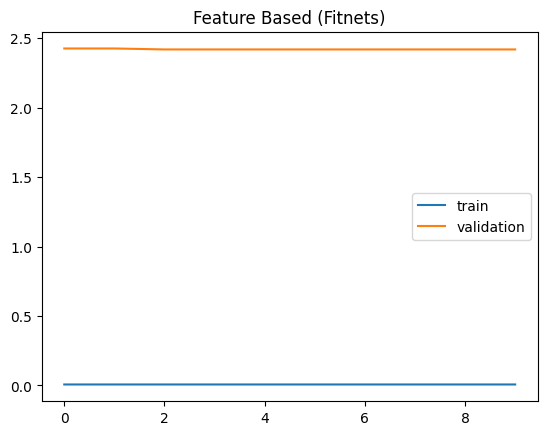

In [84]:
student_guided = Student().to(device)
student_gur, train_loss, val_loss = distiller_reg(teacher, student_guided, alpha=1, temperature=5)

In [85]:
# Save the model and losses
torch.save(student_gur.state_dict(), '/content/drive/MyDrive/student_fer.pth')

np.save('/content/drive/MyDrive/student_fer(1,5)_train_loss.npy', train_loss)
np.save('/content/drive/MyDrive/student_fer(1,5)_val_loss.npy', val_loss)

In [86]:
path =  '/content/drive/MyDrive/student_fer.pth'
student_gur.load_state_dict(torch.load(path))
student_gur

Student(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (S_regressor): Conv2d(32, 64, kernel_size=(13, 13), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=1600, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

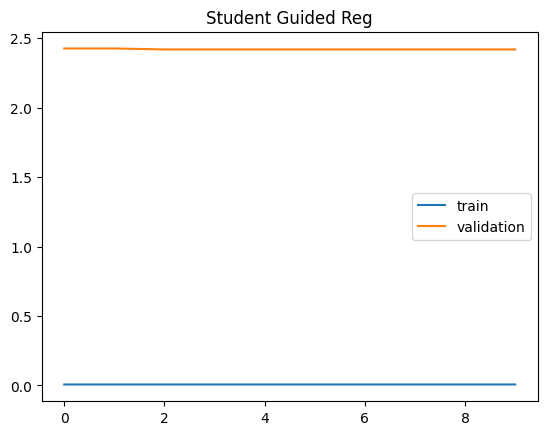

In [87]:
# Plot losses
train_loss = np.load('/content/drive/MyDrive/student_fer(1,5)_train_loss.npy')
val_loss = np.load('/content/drive/MyDrive/student_fer(1,5)_val_loss.npy')

plot_losses(train_loss, val_loss, 'Student Guided Reg')


In [88]:
# Get Metrics
acc,p,re,f1 = get_metrics(student_gur)
print("Accuracy: ", acc)
print("Precision: ", p)
print("Recall: ", re)
print("F1 Score: ", f1)


Accuracy:  0.1
Precision:  0.01
Recall:  0.1
F1 Score:  0.01818181818181818


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
